## What I want to achieve

Based on my current knowledge of python and machine learning, I want to be able to run an ensemble to algos to predict titanic survival. Gosh, we're still into that. I hope I dont ever have to touch this or the iris dataset in a years time...Thanks to [Bugra Akyildiz](http://bugra.github.io/work/notes/2014-11-22/an-introduction-to-supervised-learning-scikit-learn/) for a great blog on supervised learning. Check it out and weep with joy!

Ok, so what do we need to do? - Binary classification of survival

## Admin stuff

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

from IPython.display import Image

import pandas as pd
pd.set_option('display.max_columns', None) # Display any number of columns

import numpy as np
from matplotlib import pyplot
%matplotlib inline

# Set seaborn aesthetic parameters to defaults
import seaborn as sns
sns.set()

# scikit learn packages
import sklearn
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

C:\Users\M042266\.conda\envs\titanic_kaggle\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Read the training dataset

In [2]:
train = pd.read_csv('train.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Data wrangling from the lessons learned during the exploratory session

### Quick explorations

In [3]:
# check the class distribution of the response variable
print train.Survived.value_counts()

train.Survived.value_counts()/train.shape[0]*100

0    549
1    342
Name: Survived, dtype: int64


0    61.616162
1    38.383838
Name: Survived, dtype: float64

Almost 60:40 split. Looks cool to me. No class imbalance.

In [4]:
# quick test to see if passenger id is indeed unique and can be used as the index
print len(train.PassengerId), len(train.PassengerId.unique())

891 891


In [5]:
# fill up age variable with righteous values i.e. median age
print train.Age.isnull().sum()
train['Age'].fillna(train['Age'].median(), inplace = True)
print train.Age.isnull().sum()

177
0


In [6]:
# check out SibSp and Parch features
print train.SibSp.isnull().sum()
print train.Parch.isnull().sum()
print train.Fare.isnull().sum()
print train.Embarked.isnull().sum()

0
0
0
2


In [7]:
train.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [8]:
train.Embarked.value_counts()

# most of them seem to be from Southampton S, so encode the 2 remaining null values as 'S'

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
train.Sex.value_counts()/len(train)*100

male      64.758698
female    35.241302
Name: Sex, dtype: float64

In [10]:
# check how many rows have cabin level information
print train.Cabin.isnull().sum(), "pax dont have cabin level information"

# what about ticket info
print train.Ticket.isnull().sum(), "pax are travelling ticketless. However,...."

# however, multiple people could be travelling on the same ticket. Lets see if thats the case
print len(train.Ticket) - len(train.Ticket.drop_duplicates()), "pax are travelling on another passengers tickets."

687 pax dont have cabin level information
0 pax are travelling ticketless. However,....
210 pax are travelling on another passengers tickets.


### Create a function to do the data cleansing for us

In [11]:
def titanic_wrangling(raw_dataset):
    
    # convert the passengerid column into index. I've already checked that this field is unique per row.
    clean_dataset = raw_dataset.set_index('PassengerId', drop=True)
    
    # there's heaps of null ages. I got this from the exploratory session in the previous workbooks. Fill with 
    # median age of the passengers
    clean_dataset['Age'].fillna(clean_dataset['Age'].median(), inplace = True)
    
    # theres 2 null embarked rows. I'm coding these as 'S' fo reasons described above
    clean_dataset['Embarked'].fillna('S', inplace = True)
  
    # Encode string values into discrete integers
    #import & instantiate
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    # fit & transform SEX variable into discrete integer values
    clean_dataset['Sex'] = label_encoder.fit_transform(clean_dataset['Sex'])
    # fit & transform EMBARKED variable into discrete integer values
    clean_dataset['Embarked'] = label_encoder.fit_transform(clean_dataset['Embarked'])
    # fit & transform TICKET variable into discrete integer values. Given 210 pax have dup tickets, this could be 
    # predictive.
    clean_dataset['Ticket'] = label_encoder.fit_transform(clean_dataset['Ticket'])
    
    # Drop redundant columns from the clean dataset
    # note that I'm removing the cabin information for now, because there is too much scope for overfitting here 
    # notice also that I'm dropping Survived because I've already created the response variable
    clean_dataset.drop(['Name','Cabin'], axis=1, inplace=True)
    
    # make sure that there are no nulls in the clean dataset because numpy matrix (and consequently sklearn) can't 
    # tolerate nulls
    assert clean_dataset.isnull().values.any() == False
    
    return clean_dataset

__Future Improvement #1:__ Note here that encoding categorical features into integers has introduced implicit ordering in the Sex and Ticket variable. Strings are not inherently ordered, but integers are. We could transform these string features by creating dummy features. This can be achieved by: <br\> a) using sklearn.preprocessing.OneHotEncoder, or <br\> b) using the pandas method pd.get_dummies()<br\>
__Future Improvement #2:__ Dont impute age variable only using the median age. We can use some more smarts on this. Based on the gender, class and the salutation (Mr, Mrs, Master, Miss etc.), we can get a better sense of the ages by grouping them on these lines<br\>
__Future Improvement #3:__ Apply some more smarts around the family variables SibSp and Parch instead of simply putting it there. Example, children with parents surely have a much better chance of survival. So create variables such as married with spouses present, children with parents etc. kind of variables under the head family status

### Use the data wrangling function to give us our features and labels

In [12]:
# Get the response variable from the original train dataset as a numpy matrix
y = train['Survived'].as_matrix().astype(int)

# since the response variable has already been isolated, remove this variable from the training dataset 
# so as to get it ready for further munging
train.drop(['Survived'], axis=1, inplace=True)

In [13]:
# munge your features and convert into a numpy matrix
df_train_cleaned = titanic_wrangling(train)
X = df_train_cleaned.as_matrix().astype(np.float)

In [14]:
print X.shape, y.shape

(891L, 8L) (891L,)


In [15]:
X

array([[   3.    ,    1.    ,   22.    , ...,  523.    ,    7.25  ,    2.    ],
       [   1.    ,    0.    ,   38.    , ...,  596.    ,   71.2833,    0.    ],
       [   3.    ,    0.    ,   26.    , ...,  669.    ,    7.925 ,    2.    ],
       ..., 
       [   3.    ,    0.    ,   28.    , ...,  675.    ,   23.45  ,    2.    ],
       [   1.    ,    1.    ,   26.    , ...,    8.    ,   30.    ,    0.    ],
       [   3.    ,    1.    ,   32.    , ...,  466.    ,    7.75  ,    1.    ]])

Looks like the features are clearly in need of some scaling and standardisation...

### Perform scaling

In [16]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
# the standardscaler subtracts mean and divides by stdev

# standardised X - this has mean 0 and stdev 1
X

array([[ 0.82737724,  0.73769513, -0.56573646, ...,  0.91896631,
        -0.50244517,  0.58595414],
       [-1.56610693, -1.35557354,  0.66386103, ...,  1.28262456,
         0.78684529, -1.9423032 ],
       [ 0.82737724, -1.35557354, -0.25833709, ...,  1.64628282,
        -0.48885426,  0.58595414],
       ..., 
       [ 0.82737724, -1.35557354, -0.1046374 , ...,  1.67617254,
        -0.17626324,  0.58595414],
       [-1.56610693,  0.73769513, -0.25833709, ..., -1.64656796,
        -0.04438104, -1.9423032 ],
       [ 0.82737724,  0.73769513,  0.20276197, ...,  0.63501397,
        -0.49237783, -0.67817453]])

### Cross validation

In [17]:
cv_url = 'https://www.researchgate.net/profile/Min-Yuan_Cheng/publication/260399256/figure/fig4/ \
AS:297311155572744@1447895911905/Fig-4-Differential-Evolution-based-cross-validation-process.png'
Image(url=cv_url)

# Perform cross validation because ¯\_(ツ)_/¯

In [18]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    for train_index, test_index in stratified_k_fold:
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

Using stratification because there is a 60:40 class imbalance. which isn't a massive problem, but no harm in using it.

#### Run different algorithms and find accuracy score

In [19]:
print('Passive Aggressive Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))

Passive Aggressive Classifier: 0.74
Gradient Boosting Classifier:  0.85
Support vector machine(SVM):   0.83
Random Forest Classifier:      0.81
K Nearest Neighbor Classifier: 0.79
Logistic Regression:           0.80


Notice how ensembles and SVM have done quite well.

The dumb classifier is the name given to a naive classifier. In its most trivial case, we can say that all of them died. To make it slightly more intelligent, we can design a naive classifier where all women live, and all men don't survive.

If you inspect X, you'll see that the standard scaler has reduced the sex variable to 0.73769513 for male and -1.35557354 for female. Let's use this to make a decision variable

In [20]:
print('Dumb classifier: {:.2f}'.format(metrics.accuracy_score(y, [0 for index in y.tolist()])))
print('Gender classifier: {:.2f}'.format(metrics.accuracy_score(y, [index[1]<0 for index in X])))

Dumb classifier: 0.62
Gender classifier: 0.79


You can see that most classifiers don't give a much better accuracy than simply claiming that all men died and all women survived. Confusion matrices give us a better understanding of the errors in our predictionz

### Run confusion matrices

In [21]:
pass_agg_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))
grad_ens_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))
decision_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, tree.DecisionTreeClassifier))
ridge_clf_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.RidgeClassifier))
svm_svc_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, svm.SVC))
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier))
k_neighbors_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))
logistic_reg_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression))
gender_conf_matrix = metrics.confusion_matrix(y, [index[1]<0 for index in X]); 
dumb_conf_matrix = metrics.confusion_matrix(y, [0 for index in y.tolist()]); # ignore the warning as they are all 0


conf_matrix = {
                1: {
                    'matrix': pass_agg_conf_matrix,
                    'title': 'Passive Aggressive',
                   },
                2: {
                    'matrix': grad_ens_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                3: {
                    'matrix': decision_conf_matrix,
                    'title': 'Decision Tree',
                   },
                4: {
                    'matrix': ridge_clf_conf_matrix,
                    'title': 'Ridge',
                   },
                5: {
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                   },
                6: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                7: {
                    'matrix': k_neighbors_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
                8: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',
                   },
                9: {
                    'matrix': gender_conf_matrix,
                    'title': 'Gender business rule',
                   },
                10: {
                    'matrix': dumb_conf_matrix,
                    'title': 'Dumb',
                   },
}

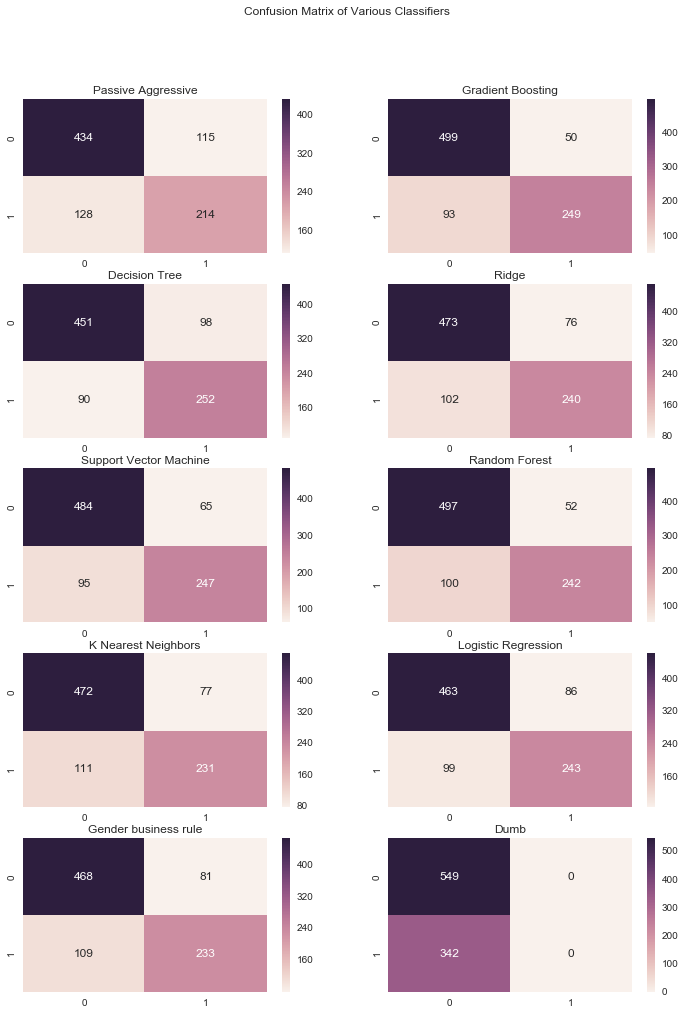

In [22]:
fix, ax = plt.subplots(figsize=(12, 16))
plt.suptitle('Confusion Matrix of Various Classifiers')
for index, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(5, 2, index) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='');

Look at f1 scores using the classification report:

In [23]:
print('Passive Aggressive Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Decision Tree Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, tree.DecisionTreeClassifier))))
print('Ridge Regression Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.RidgeClassifier))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Gender based Classifier:\n {}\n'.format(metrics.classification_report(y, [index[1]<0 for index in X])));
print('Dumb Classifier:\n {}\n'.format(metrics.classification_report(y, [0 for index in y.tolist()]))); #ignore warnings because of all the 0s

Passive Aggressive Classifier:
              precision    recall  f1-score   support

          0       0.76      0.74      0.75       549
          1       0.60      0.63      0.62       342

avg / total       0.70      0.70      0.70       891


Gradient Boosting Classifier:
              precision    recall  f1-score   support

          0       0.84      0.91      0.88       549
          1       0.84      0.73      0.78       342

avg / total       0.84      0.84      0.84       891


Decision Tree Classifier:
              precision    recall  f1-score   support

          0       0.83      0.79      0.81       549
          1       0.69      0.73      0.71       342

avg / total       0.77      0.77      0.77       891


Ridge Regression Classifier:
              precision    recall  f1-score   support

          0       0.82      0.86      0.84       549
          1       0.75      0.70      0.72       342

avg / total       0.79      0.80      0.79       891


Support vector m

C:\Users\M042266\.conda\envs\titanic_kaggle\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Using different types of model evaluation metrics, we can see that ensemble techniques like gradient boosting and random forest wins handsomely. SVM is also not far behind.

### Most important features

In [24]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

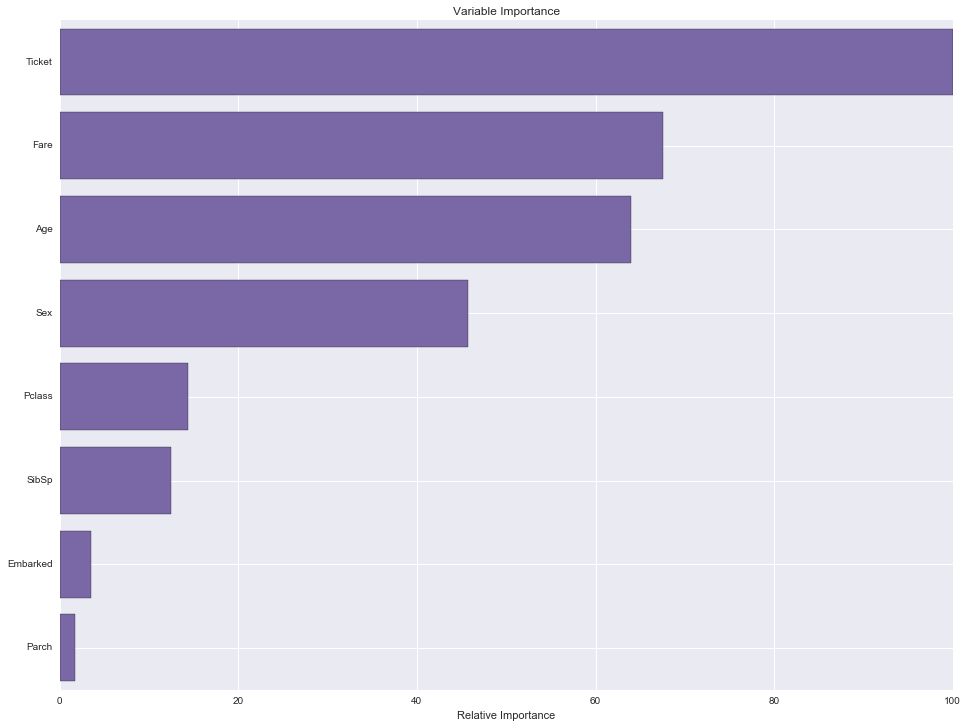

In [25]:
# Get Feature Importance from the classifier
feature_importance = gbc.feature_importances_
# Normalize The Features
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(16, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
plt.yticks(pos, np.asanyarray(df_train_cleaned.columns.tolist())[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It's illuminating that ticket, fare and age are the three most indicative variables. These variables are way too specific, and it's more than likely that we've overfit the model to training data. <br\>
__Future Improvement #4__: Feature engineer age groups and fare groups. Also create derived column for share_ticket.<br\>
__Future Improvement #5__: Create scaled polynomial features<br\>
__Future Improvement #6__: Alternate strategy is to test whether one-hot encoding of features is a better idea 

### But for now, let's simply check the results on the test set...

#### Read the test set

In [26]:
test = pd.read_csv('test.csv')
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


#### Perform the same data munging on the test dataset

In [27]:
df_test_cleaned = titanic_wrangling(test)

AssertionError: 

Notice that the test data munging returned an assertion error. This means that one or more values in X_test is null

In [28]:
# check which column has nulls, and also find out how many nulls
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Our titanic_wrangling function fixes the nulls for Age. We drop the Cabin feature anyways. So "Fare" is the only feature where we don't handle nulls in our training function. 

In [29]:
# there's no other way to fix null fares except to replace it with a 0
test.Fare.fillna(0, inplace = True)

print "the number of nulls after fixing the issue is: ", test.isnull().sum()

the number of nulls after fixing the issue is:  PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [30]:
df_test_cleaned = titanic_wrangling(test)
X_t = df_test_cleaned.as_matrix().astype(np.float)
print X_t.shape

(418L, 8L)


#### Perform scaling

In [31]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_t = scaler.fit_transform(X_t)
# the standardscaler subtracts mean and divides by stdev

# standardised X_t - this has mean 0 and stdev 1
X_t

array([[ 0.87348191,  0.75592895,  0.38623105, ..., -0.26949361,
        -0.49663711, -0.47091535],
       [ 0.87348191, -1.32287566,  1.37137004, ...,  0.37293425,
        -0.5114971 ,  0.70076689],
       [-0.31581919,  0.75592895,  2.55353683, ..., -1.00502694,
        -0.46333473, -0.47091535],
       ..., 
       [ 0.87348191,  0.75592895,  0.70147553, ...,  1.53675282,
        -0.50701688,  0.70076689],
       [ 0.87348191,  0.75592895, -0.20485235, ...,  0.3636237 ,
        -0.49268018,  0.70076689],
       [ 0.87348191,  0.75592895, -0.20485235, ..., -0.70708939,
        -0.23626278, -1.64259759]])

### Predict X_t based on the gbm model

In [32]:
# directly writing the predicted survivals to test (dataframe)
df_test_cleaned['Survived'] = gbc.predict(X_t)

In [33]:
df_test_cleaned.head(3)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
PassengerId,,,,,,,,,
892,3,1,34.5,0,0,152,7.8292,1,0
893,3,0,47.0,1,0,221,7.0000,2,0
894,2,1,62.0,0,0,73,9.6875,1,0


## Write to submission file

In [34]:
df_test_cleaned.to_csv('3submission_basic_munging_gbm.csv',columns = ['Survived'])

## Assessing model performance

### Baseline model - null model

All passengers in test set dead. Because "did not survive" is the majority class. 

In [35]:
firstsubmission = pd.read_csv('test.csv')

In [36]:
# create a baseline Survival prediction by predicting everyone in the test set to the majority class i.e. dead
firstsubmission['Survived'] = 0

# remove pandas index and keep passengerid as index
firstsubmission.set_index('PassengerId', inplace = True)

firstsubmission.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0


In [37]:
# write to file
firstsubmission.to_csv('1submission_null_model.csv',columns = ['Survived'])

Submitting this got me a score of __0.62679__<br\>

### Improved model - gender model

I didn't code this specifically because kaggle has already provided this data to us. But I made this my first submission which will act as baseline model

In [38]:
secondsubmission = pd.read_csv('2submission_gendermodel.csv')
secondsubmission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


Submitting this got me a score of __0.76555__<br\>
My rank is __3823__

### Third model - encoder+gbm model

This is the model from our adventures so far.

In [39]:
thirdsubmission = pd.read_csv('3submission_basic_munging_gbm.csv')
thirdsubmission.head(3)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0


Submitting this got me a score of __0.77033__<br\>
My rank is __3082__